In [5]:
Nan_matters_col = ['OCCUPATION_TYPE',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'ELEVATORS_AVG',
 'ENTRANCES_AVG',
 'FLOORSMAX_AVG',
 'LIVINGAREA_AVG',
 'NONLIVINGAREA_AVG',
 'APARTMENTS_MODE',
 'BASEMENTAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'ELEVATORS_MODE',
 'ENTRANCES_MODE',
 'FLOORSMAX_MODE',
 'LIVINGAREA_MODE',
 'NONLIVINGAREA_MODE',
 'APARTMENTS_MEDI',
 'BASEMENTAREA_MEDI',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'ELEVATORS_MEDI',
 'ENTRANCES_MEDI',
 'FLOORSMAX_MEDI',
 'LIVINGAREA_MEDI',
 'NONLIVINGAREA_MEDI',
 'HOUSETYPE_MODE',
 'TOTALAREA_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR']

In [6]:

import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)


@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))


# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns


# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows=None, nan_as_category=False):
    # Read data and merge
    df = pd.read_csv('../../data/application_train.csv', nrows=num_rows)
    test_df = pd.read_csv('../../data/application_test.csv', nrows=num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']

    docs = [_f for _f in df.columns if 'FLAG_DOC' in _f]
    live = [_f for _f in df.columns if ('FLAG_' in _f) & ('FLAG_DOC' not in _f) & ('_FLAG_' not in _f)]

    # 我添加的
    df['DAYS_EMPLOYED_365243'] = df['DAYS_EMPLOYED'].map(lambda x: 1 if x == 365243 else 0 if not pd.isnull(x) else np.nan)
    for col in Nan_matters_col:
        df[col+'_NAN'] = df[col].map(lambda x: 1 if  pd.isnull(x) else 0)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

    inc_by_org = df[['AMT_INCOME_TOTAL', 'ORGANIZATION_TYPE']].groupby('ORGANIZATION_TYPE').median()['AMT_INCOME_TOTAL']

    df['NEW_CREDIT_TO_ANNUITY_RATIO'] = df['AMT_CREDIT'] / df['AMT_ANNUITY']
    df['NEW_CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
    df['NEW_DOC_IND_KURT'] = df[docs].kurtosis(axis=1)
    df['NEW_LIVE_IND_SUM'] = df[live].sum(axis=1)
    df['NEW_INC_PER_CHLD'] = df['AMT_INCOME_TOTAL'] / (1 + df['CNT_CHILDREN'])
    df['NEW_INC_BY_ORG'] = df['ORGANIZATION_TYPE'].map(inc_by_org)
    df['NEW_EMPLOY_TO_BIRTH_RATIO'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['NEW_ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / (1 + df['AMT_INCOME_TOTAL'])
    df['NEW_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['NEW_EXT_SOURCES_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    df['NEW_SCORES_STD'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    df['NEW_SCORES_STD'] = df['NEW_SCORES_STD'].fillna(df['NEW_SCORES_STD'].mean())
    df['NEW_CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
    df['NEW_CAR_TO_EMPLOY_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
    df['NEW_PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']
    df['NEW_PHONE_TO_BIRTH_RATIO_EMPLOYER'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_EMPLOYED']
    df['NEW_CREDIT_TO_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']

    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    dropcolum = ['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_4',
                 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7',
                 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10',
                 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13',
                 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16',
                 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19',
                 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']
    df = df.drop(dropcolum, axis=1)
    del test_df
    gc.collect()
    return df


# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows=None, nan_as_category=True):
    bureau = pd.read_csv('../../data/bureau.csv', nrows=num_rows)
    bb = pd.read_csv('../../data/bureau_balance.csv', nrows=num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)

    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace=True)
    del bb, bb_agg
    gc.collect()

    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']

    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg


# Preprocess previous_applications.csv
def previous_applications(num_rows=None, nan_as_category=True):
    prev = pd.read_csv('../../data/previous_application.csv', nrows=num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category=True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['max', 'mean'],
        'AMT_APPLICATION': ['max', 'mean'],
        'AMT_CREDIT': ['max', 'mean'],
        'APP_CREDIT_PERC': ['max', 'mean'],
        'AMT_DOWN_PAYMENT': ['max', 'mean'],
        'AMT_GOODS_PRICE': ['max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['max', 'mean'],
        'RATE_DOWN_PAYMENT': ['max', 'mean'],
        'DAYS_DECISION': ['max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']

    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg


# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows=None, nan_as_category=True):
    pos = pd.read_csv('../../data/POS_CASH_balance.csv', nrows=num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category=True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']

    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg


# Preprocess installments_payments.csv
def installments_payments(num_rows=None, nan_as_category=True):
    ins = pd.read_csv('../../data/installments_payments.csv', nrows=num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category=True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum', 'min', 'std'],
        'DBD': ['max', 'mean', 'sum', 'min', 'std'],
        'PAYMENT_PERC': ['max', 'mean', 'var', 'min', 'std'],
        'PAYMENT_DIFF': ['max', 'mean', 'var', 'min', 'std'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum', 'min', 'std'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum', 'std'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum', 'std']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg


# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows=None, nan_as_category=True):
    cc = pd.read_csv('../../data/credit_card_balance.csv', nrows=num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category=True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis=1, inplace=True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg


# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified=False, debug=False):
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=47)
    else:
        folds = KFold(n_splits=num_folds, shuffle=True, random_state=47)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']]

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        
        # 自己做bayes的参数
#         clf = LGBMClassifier(
#             nthread=8,
#             # is_unbalance=True,
#             n_estimators=10000,
#             learning_rate=0.01,
#             num_leaves=43,
#             colsample_bytree=0.6558,
#             subsample=0.8927,
#             max_depth=14,
#             reg_alpha=1.4957,
#             reg_lambda=8.5621,
#             min_split_gain=0.4919,
#             min_child_weight=30,
#             silent=-1,
#             verbose=-1,
#             # scale_pos_weight=11
#         )
        
        
          # 原始参数
        clf = LGBMClassifier(
            nthread=4,
            # is_unbalance=True,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=32,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.04,
            reg_lambda=0.073,
            min_split_gain=0.0222415,
            min_child_weight=40,
            silent=-1,
            verbose=-1,
            # scale_pos_weight=11
        )

        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)],
                eval_metric='auc', verbose=1000, early_stopping_rounds=200)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index=False)
    display_importances(feature_importance_df)
    return feature_importance_df


# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance",
                                                                                                   ascending=False)[
           :40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')


def main(debug=False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    with timer("Run LightGBM with kfold"):
        feat_importance = kfold_lightgbm(df, num_folds=5, stratified=False, debug=debug)


# if __name__ == "__main__":
#     submission_file_name = "submission_kernel02_11.csv"
#     with timer("Full model run"):
#         main()

In [7]:
debug = False


num_rows = 10000 if debug else None
df = application_train_test(num_rows)
with timer("Process bureau and bureau_balance"):
    bureau = bureau_and_balance(num_rows)
    print("Bureau df shape:", bureau.shape)
    df = df.join(bureau, how='left', on='SK_ID_CURR')
    del bureau
    gc.collect()
with timer("Process previous_applications"):
    prev = previous_applications(num_rows)
    print("Previous applications df shape:", prev.shape)
    df = df.join(prev, how='left', on='SK_ID_CURR')
    del prev
    gc.collect()
with timer("Process POS-CASH balance"):
    pos = pos_cash(num_rows)
    print("Pos-cash balance df shape:", pos.shape)
    df = df.join(pos, how='left', on='SK_ID_CURR')
    del pos
    gc.collect()
with timer("Process installments payments"):
    ins = installments_payments(num_rows)
    print("Installments payments df shape:", ins.shape)
    df = df.join(ins, how='left', on='SK_ID_CURR')
    del ins
    gc.collect()
with timer("Process credit card balance"):
    cc = credit_card_balance(num_rows)
    print("Credit card balance df shape:", cc.shape)
    df = df.join(cc, how='left', on='SK_ID_CURR')
    del cc
    gc.collect()
# with timer("Run LightGBM with kfold"):
#     feat_importance = kfold_lightgbm(df, num_folds=11, stratified=False, debug=debug)

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 95)
Process bureau and bureau_balance - done in 22s
Previous applications df shape: (338857, 219)
Process previous_applications - done in 18s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 12s
Installments payments df shape: (339587, 36)
Process installments payments - done in 34s
Credit card balance df shape: (103558, 113)
Process credit card balance - done in 14s


In [8]:
# df.to_csv("../../data/handled/kernel_1/df_all.csv")

Starting LightGBM. Train shape: (307507, 757), test shape: (48744, 757)
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.858233	valid_1's auc: 0.791894
[2000]	training's auc: 0.900087	valid_1's auc: 0.793338
Early stopping, best iteration is:
[2061]	training's auc: 0.902256	valid_1's auc: 0.79344
Fold  1 AUC : 0.793440
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.858087	valid_1's auc: 0.788422
Early stopping, best iteration is:
[1615]	training's auc: 0.885415	valid_1's auc: 0.789584
Fold  2 AUC : 0.789584
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.85829	valid_1's auc: 0.789896
Early stopping, best iteration is:
[1682]	training's auc: 0.888733	valid_1's auc: 0.791055
Fold  3 AUC : 0.791055
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.858921	valid_1's auc: 0.790279
Early stopping, best iteration is:
[1497]	training's auc

/usr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Run LightGBM with kfold - done in 1979s


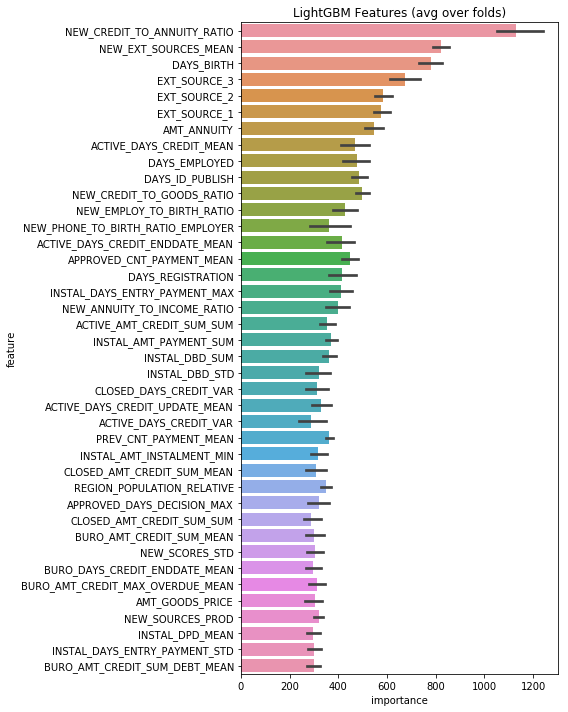

In [9]:
# add 365243
submission_file_name = 'submission_kernel1_add_365243.csv'
with timer("Run LightGBM with kfold"):
        feat_importance = kfold_lightgbm(df, num_folds=5, stratified=False, debug=debug)

Starting LightGBM. Train shape: (307507, 721), test shape: (48744, 721)
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.855661	valid_1's auc: 0.790132
[2000]	training's auc: 0.896621	valid_1's auc: 0.791713
Early stopping, best iteration is:
[2260]	training's auc: 0.904863	valid_1's auc: 0.792074
Fold  1 AUC : 0.792074
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.854825	valid_1's auc: 0.789593
[2000]	training's auc: 0.895441	valid_1's auc: 0.792717
Early stopping, best iteration is:
[2330]	training's auc: 0.905953	valid_1's auc: 0.793135
Fold  2 AUC : 0.793135
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.855318	valid_1's auc: 0.792475
[2000]	training's auc: 0.896518	valid_1's auc: 0.793571
Early stopping, best iteration is:
[1911]	training's auc: 0.893296	valid_1's auc: 0.79371
Fold  3 AUC : 0.793710
Training until validation scores don't improve for 200 rounds.

/usr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:346: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Run LightGBM with kfold - done in 3216s


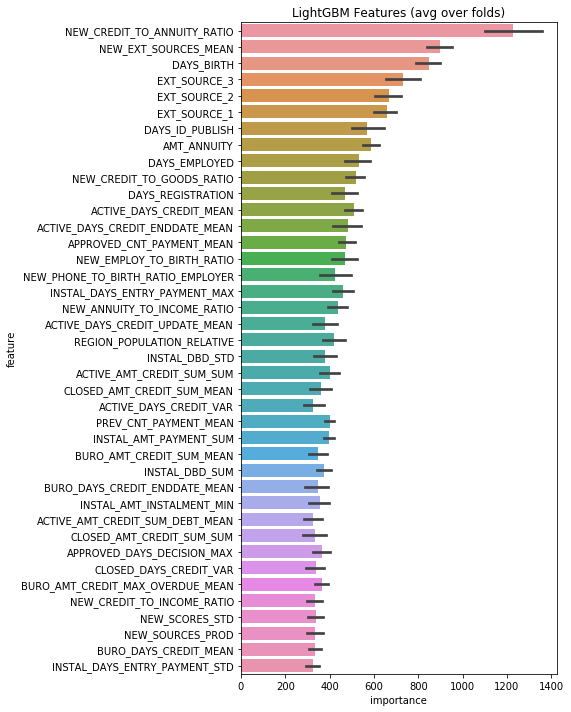

In [5]:
# fold = 7
submission_file_name = 'submission_kernel1.csv'
with timer("Run LightGBM with kfold"):
        feat_importance = kfold_lightgbm(df, num_folds=5, stratified=False, debug=debug)

Starting LightGBM. Train shape: (307507, 721), test shape: (48744, 721)
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.857885	valid_1's auc: 0.792147
Early stopping, best iteration is:
[1593]	training's auc: 0.885066	valid_1's auc: 0.793334
Fold  1 AUC : 0.793334
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.858463	valid_1's auc: 0.788323
Early stopping, best iteration is:
[1676]	training's auc: 0.88789	valid_1's auc: 0.7896
Fold  2 AUC : 0.789600
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.858565	valid_1's auc: 0.789922
Early stopping, best iteration is:
[1468]	training's auc: 0.880148	valid_1's auc: 0.791146
Fold  3 AUC : 0.791146
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.858625	valid_1's auc: 0.790009
Early stopping, best iteration is:
[1347]	training's auc: 0.875416	valid_1's auc: 0.790719
Fold  4 AUC : 0.790719

/usr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:346: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Run LightGBM with kfold - done in 1802s


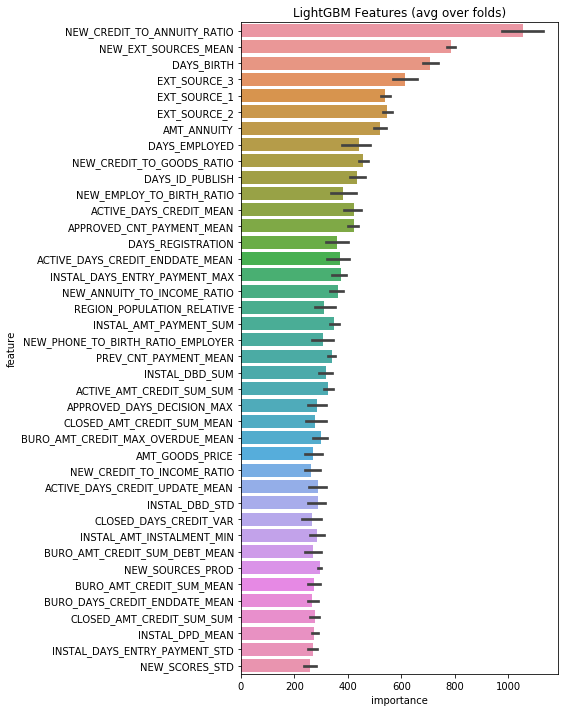

In [3]:
submission_file_name = 'submission_kernel1_with_my_bayes_opt.csv'
with timer("Run LightGBM with kfold"):
        feat_importance = kfold_lightgbm(df, num_folds=5, stratified=False, debug=debug)

# 合并我自己的特征

In [4]:
df_train = pd.read_csv("../../data/handled/train.csv", index_col=0)
df_test = pd.read_csv("../../data/handled/test.csv", index_col=0)

(356251, 721)

In [14]:
gen_columns = [i for i in df_train.columns if "_DUMMY" in i]

df_train = df_train[gen_columns]

df_test = df_test[gen_columns]

temp = pd.concat((df_train, df_test))

df = df.join(temp, how='left', on='SK_ID_CURR')

# 合并我的Stacking特征

In [7]:
my_feature = pd.read_csv("../../data/handled/kernel_1/my_features.csv", index_col=0, header=0)

In [9]:
df = df.join(my_feature, how='left', on='SK_ID_CURR')

Starting LightGBM. Train shape: (307507, 724), test shape: (48744, 724)
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[242]	training's auc: 0.807685	valid_1's auc: 0.79001
Fold  1 AUC : 0.790010
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[239]	training's auc: 0.808625	valid_1's auc: 0.786716
Fold  2 AUC : 0.786716
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[253]	training's auc: 0.808599	valid_1's auc: 0.789049
Fold  3 AUC : 0.789049
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[237]	training's auc: 0.807654	valid_1's auc: 0.789473
Fold  4 AUC : 0.789473
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[222]	training's auc: 0.807584	valid_1's auc: 0.785319
Fold  5 AUC : 0.785319
Full AUC score 0.788038


/usr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:346: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Run LightGBM with kfold - done in 559s


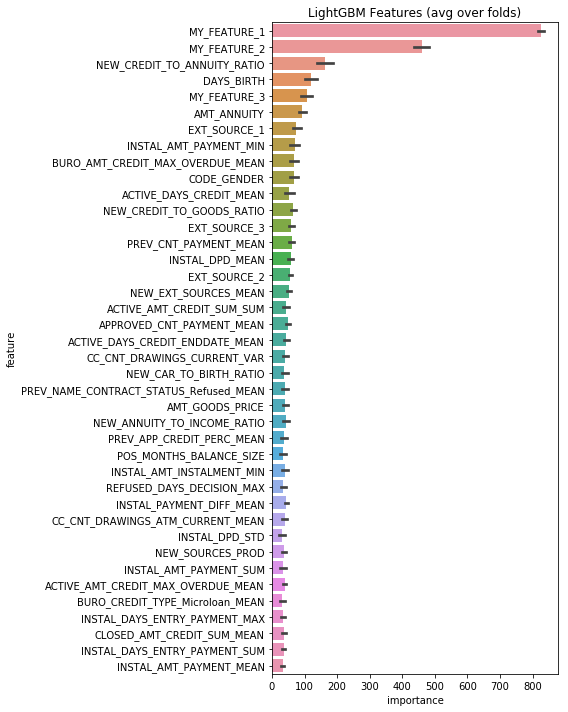

In [10]:
submission_file_name = 'submission_kernel1_stacking_feature.csv'
with timer("Run LightGBM with kfold"):
        feat_importance = kfold_lightgbm(df, num_folds=5, stratified=False, debug=debug)

In [16]:
selected_features = list(np.unique(feat_importance.loc[feat_importance.importance >= 50].feature))

In [17]:
selected_features += ['TARGET', 'SK_ID_CURR', 'SK_ID_BUREAU', 'SK_ID_PREV', 'index']

In [18]:
df = df.loc[:, selected_features]

Starting LightGBM. Train shape: (307507, 335), test shape: (48744, 335)
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.858608	valid_1's auc: 0.791758
[2000]	training's auc: 0.901399	valid_1's auc: 0.793213
Early stopping, best iteration is:
[1830]	training's auc: 0.89559	valid_1's auc: 0.793302
Fold  1 AUC : 0.793302
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.859012	valid_1's auc: 0.788465
[2000]	training's auc: 0.901715	valid_1's auc: 0.789186
Early stopping, best iteration is:
[1936]	training's auc: 0.899478	valid_1's auc: 0.789351
Fold  2 AUC : 0.789351
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.858885	valid_1's auc: 0.788647
Early stopping, best iteration is:
[1753]	training's auc: 0.892697	valid_1's auc: 0.789652
Fold  3 AUC : 0.789652
Training until validation scores don't improve for 200 rounds.
[1000]	training's auc: 0.858782	valid_1's auc: 0.790273

/usr/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:346: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Run LightGBM with kfold - done in 1549s


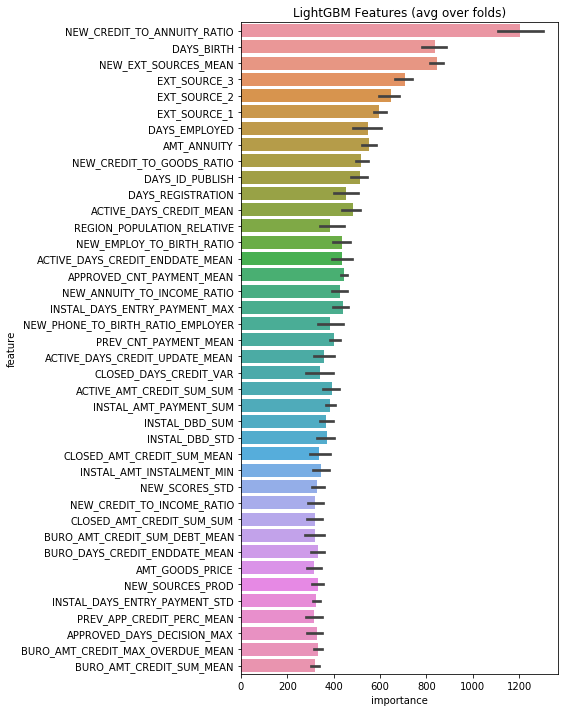

In [19]:
submission_file_name = 'submission_kernel1_featselect.csv'
with timer("Run LightGBM with kfold"):
        feat_importance = kfold_lightgbm(df, num_folds=5, stratified=False, debug=debug)

In [23]:
feat_importance.to_csv("feature_importance_330.csv")